In [1]:
import torch as t
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from einops import rearrange
from fancy_einsum import einsum

from typing import Union, Tuple, Callable, Optional
from tqdm.notebook import tqdm_notebook
import plotly.express as px

import utils
from scratch_cnn import *

In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 32, 3, padding=1)
        self.relu1 = ReLU()
        self.pool1 = MaxPool2d((2, 2))
        self.conv2 = Conv2d(32, 64, 3, padding=1)
        self.relu2 = ReLU()
        self.pool2 = MaxPool2d((2, 2))
        self.flat1 = Flatten()
        self.fc1 = Linear(3136, 128)
        self.fc2 = Linear(128, 10)

    def forward(self, x: t.Tensor) -> t.Tensor:
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flat1(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = ConvNet()
print(model)

ConvNet(
  (conv1): Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=None, padding=0)
  (conv2): Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=None, padding=0)
  (flat1): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testset = datasets.MNIST(root="./data", train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64)

In [4]:
def train_convnet(
    trainloader: DataLoader,
    testloader: DataLoader,
    epochs: int,
    loss_fn: Callable
) -> list:
    '''
    Defines a ConvNet using our previous code, and trains it on the data in trainloader.
    '''

    model = ConvNet().to(device).train()
    optimizer = t.optim.Adam(model.parameters())
    loss_list = []
    accuracy_list = []

    for epoch in tqdm_notebook(range(epochs)):

        for (x, y) in tqdm_notebook(trainloader, leave=False):

            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()

            loss_list.append(loss.item())

        # Get test accuracy at end of epoch
        n_correct = 0
        for (x, y) in testloader:
            x = x.to(device)
            y = y.to(device)

            with t.no_grad():
                outputs = model(x)

            n_correct += (outputs.argmax(dim=1) == y).sum().item()
        accuracy = n_correct / len(testloader.dataset)
        accuracy_list.append(accuracy)
        print(f"Epoch {epoch + 1}/{epochs}, train loss is {loss:.6f}, test accuracy is {accuracy:.3f}")

    print(f"Saving model to: {MODEL_FILENAME}")
    t.save(model, MODEL_FILENAME)
    return loss_list, accuracy_list

In [5]:
epochs = 3
loss_fn = nn.CrossEntropyLoss()
batch_size = 128

MODEL_FILENAME = "./w1d2_convnet_scratch_mnist.pt"
device = "cuda" if t.cuda.is_available() else "cpu"

loss_list, accuracy_list = train_convnet(trainloader, testloader, epochs, loss_fn)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/3, train loss is 0.005420, test accuracy is 0.984


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/3, train loss is 0.652638, test accuracy is 0.989


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/3, train loss is 0.011326, test accuracy is 0.990
Saving model to: ./w1d2_convnet_mnist.pt


<AxesSubplot:>

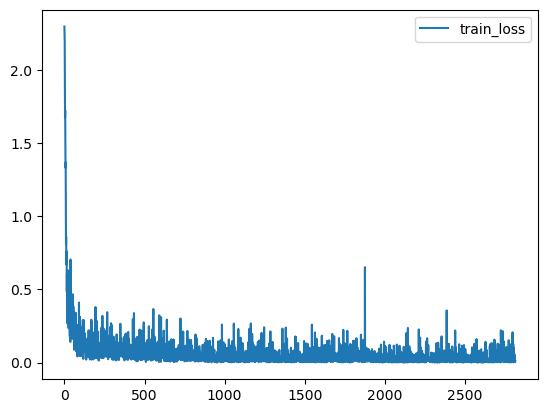

In [10]:
import pandas as pd
df_loss = pd.DataFrame(data=loss_list, columns=['train_loss'])
df_loss.plot()

In [9]:
# utils.plot_loss_and_accuracy(loss_list, accuracy_list)